In [1]:
import numpy as np
import torch
import mnist_reader
import matplotlib.pyplot as plt
from scipy.special import expit
from numpy.linalg import inv, pinv

In [3]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
print X_train, y_train
X_train = X_train/255
X_test = X_test/255
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
# pad the image for the bias
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
print('X_train padded:', X_train.shape)
print('X_test padded:', X_test.shape)

IOError: [Errno 2] No such file or directory: 'data/fashion/train-labels-idx1-ubyte.gz'

In [4]:
labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [5]:
def visualize_sample():
    idx = 1
    for i in np.random.choice(60000, 10):
        img = X_train[i][:784].reshape(28,28)
        cls_idx = y_train[i]
        plt.subplot(1, 10, idx)
        plt.imshow(img)
        plt.axis('off')
        plt.title(labels[cls_idx])
        idx += 1
    plt.imshow(img)
    
def visualize_idx(idx, X, y):
    img = X[idx][:784].reshape(28,28)
    cls_idx = y[idx]
    plt.imshow(img)
    plt.title(labels[cls_idx])
    plt.imshow(img)

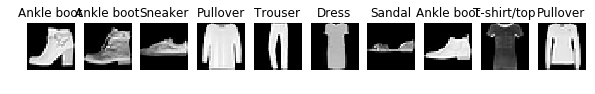

In [6]:
visualize_sample()

In [7]:
def train_val_split(X_train, y_train, val_size=0.05):
    # split train set into train and val set. split proportion will be according to val_size

    num_examples = len(y_train)
    val_indexes = np.random.choice(num_examples, int(num_examples * val_size), replace=False)

    X_val = X_train[val_indexes]
    y_val = y_train[val_indexes]

    # now get the remain indexes for train set
    mask = np.ones(num_examples, dtype=bool)
    mask[val_indexes] = False

    X_train = X_train[mask]
    y_train = y_train[mask]

    return X_train, X_val, y_train, y_val

In [8]:
#  X_train, X_val, y_train, y_val = train_val_split(X_train, y_train)

In [9]:
# print('X_train:', X_train.shape)
# print('y_train:', y_train.shape)
# print('X_valid:', X_val.shape)
# print('y_valid:', y_val.shape)
# print('X_test:', X_test.shape)
# print('y_test:', y_test.shape)

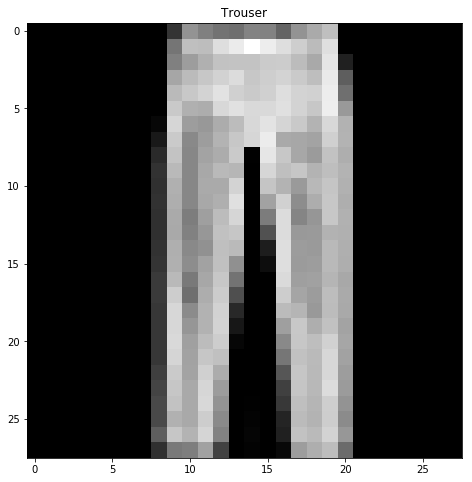

In [10]:
visualize_idx(16, X_train, y_train)

In [11]:
def data_loader(X, y, batch_size=100):
    assert X.shape[0] == len(y)
    for i in range(int(len(y)/batch_size)):
        yield X[i:i+batch_size], y[i:i+batch_size]

In [12]:
# def sigmoid(X,theta):
#     a = np.dot(X, theta)
#     return expit(a)
def decision_boundary(prob):
    return 1 * (prob >= .5)

def sigmoid(X, theta):
    return 1.0 / (1 + np.exp(- np.matmul(X, theta)))

In [13]:
def thereshold(prob):
    return 1 * (prob >= .5)

In [14]:
def cross_entropy(X, y, theta):
    eps = 1e-9 # Prevent log(0)
    return - np.sum(np.multiply(y, np.log(sigmoid(X, theta) + eps)) + np.multiply((1 - y), np.log(1 - sigmoid(X, theta) + eps)))

In [15]:
def gradient(X, y, theta):
    N = X.shape[0]
    val = np.matmul(X.T, sigmoid(X, theta) - y) / N
    return val

In [16]:
def hessian(X, y, theta):
    sig = sigmoid(X, theta)
    R = np.diag(sig * (1 - sig))
    temp = np.matmul(X.T,R)
    hess = np.matmul(temp, X)
#     print(hess, hess.shape)
    return hess


In [17]:
# create sub-dataset
def create_sub_dataset(X_train, y_train, subset_idxs):
    mask = (y_train == subset_idxs[0])
    mask1 = (y_train == subset_idxs[1])
    train_length = mask.sum()
    X_train_true = X_train[mask]
    y_train_true = y_train[mask]
    X_train_false = X_train[mask1]
    y_train_false = y_train[mask1]
    # random choose negative sample
#     false_idx = np.random.choice(len(X_train_false),train_length, replace=False)
#     X_train_false = X_train_false[false_idx]
#     y_train_false = y_train_false[false_idx]
    # merge and shuffle
    X_train = np.concatenate((X_train_true, X_train_false),axis=0)
    y_train = np.concatenate((y_train_true, y_train_false),axis=0)
    randnum = np.random.randint(0,100)
    np.random.seed(randnum)
    np.random.shuffle(X_train)
    np.random.seed(randnum)
    np.random.shuffle(y_train)
    mask = (y_train == subset_idxs[0])
    temp = np.zeros_like(y_train)
    temp[mask] = 1
    y_train = temp
    
    return X_train, y_train
    
    
# y_train_subset = np.zeros_like(y_train)
# y_train_subset[mask] = 1
# mask = (y_val == subset_idx)
# y_val_subset = np.zeros_like(y_val)
# y_val_subset[mask] = 1
# mask = (y_test == subset_idx)
# y_test_subset = np.zeros_like(y_test)
# y_test_subset[mask] = 1

In [18]:
def test(classifier, x_test, y_test):
    y_pred = decision_boundary(sigmoid(x_test, classifier))
    
    # Create confusion matrix.
    cm = np.zeros((2, 2), dtype=int)
    np.add.at(cm, [y_test, y_pred], 1)

    print("== Confusion Matrix ==")
    print(cm)
    print("== Accuracy ==")
    print((y_test == y_pred).sum()/len(y_pred))

In [19]:
# first order method 

X_train, y_train = create_sub_dataset(X_train, y_train, [3,5])
X_test, y_test = create_sub_dataset(X_test, y_test, [3,5])

theta = np.random.normal(0,1,X_train.shape[1]) # 785 x 1 initialize
# start training
lr = 0.5
epochs = 10
for epoch in range(epochs):
    empirical_loss = 0
    count = 0
    train_loader = data_loader(X_train, y_train, 12000)

    for X, y in train_loader:
        loss = cross_entropy(X, y, theta)
        grad = gradient(X, y, theta)
#         hess = hessian(X, y, theta)
        theta -= lr*grad
        empirical_loss += loss
        count += len(y)

    test(theta, X_test, y_test)    
    empirical_loss /= count
    print("epoch: {}, empirical loss: {}".format(epoch,empirical_loss))

12000
== Confusion Matrix ==
[[502 498]
 [ 30 970]]
== Accuracy ==
0.736
epoch: 0, empirical loss: 3.289523032906747
12000
== Confusion Matrix ==
[[712 288]
 [107 893]]
== Accuracy ==
0.8025
epoch: 1, empirical loss: 1.2329517910973242
12000
== Confusion Matrix ==
[[782 218]
 [100 900]]
== Accuracy ==
0.841
epoch: 2, empirical loss: 0.6164349822431388
12000
== Confusion Matrix ==
[[811 189]
 [ 81 919]]
== Accuracy ==
0.865
epoch: 3, empirical loss: 0.461685843634903
12000
== Confusion Matrix ==
[[838 162]
 [ 70 930]]
== Accuracy ==
0.884
epoch: 4, empirical loss: 0.3683737069350141
12000
== Confusion Matrix ==
[[865 135]
 [ 66 934]]
== Accuracy ==
0.8995
epoch: 5, empirical loss: 0.3066125238257473
12000
== Confusion Matrix ==
[[883 117]
 [ 59 941]]
== Accuracy ==
0.912
epoch: 6, empirical loss: 0.2631873512118238
12000
== Confusion Matrix ==
[[900 100]
 [ 54 946]]
== Accuracy ==
0.923
epoch: 7, empirical loss: 0.23124995744237012
12000
== Confusion Matrix ==
[[913  87]
 [ 52 948]]
== 

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [20]:
test(theta, X_test, y_test)

== Confusion Matrix ==
[[924  76]
 [ 47 953]]
== Accuracy ==
0.9385


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [43]:
# second order method 
randnum = np.random.randint(0,100)
np.random.seed(randnum)
print(randnum)
theta = np.random.normal(0,1,X_train.shape[1]) # 785 x 1 initialize
# start training
epochs = 100
for epoch in range(epochs):
    empirical_loss = 0
    count = 0
    train_loader = data_loader(X_train, y_train, 12000)

    for X, y in train_loader:
        loss = cross_entropy(X, y, theta)
        grad = gradient(X, y, theta)
        hess = hessian(X, y, theta)
        try:
            theta -= np.matmul(inv(hess),grad)
        except:
            theta -= np.matmul(pinv(hess),grad)

        empirical_loss += loss
        count += len(y)

    test(theta, X_test, y_test)    
    empirical_loss /= count
    print("epoch: {}, empirical loss: {}".format(epoch,empirical_loss))

85


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


== Confusion Matrix ==
[[651 349]
 [952  48]]
== Accuracy ==
0.3495
epoch: 0, empirical loss: 6.1401923022810125
== Confusion Matrix ==
[[651 349]
 [952  48]]
== Accuracy ==
0.3495
epoch: 1, empirical loss: 6.09887633429575
== Confusion Matrix ==
[[651 349]
 [952  48]]
== Accuracy ==
0.3495
epoch: 2, empirical loss: 6.05099207459729
== Confusion Matrix ==
[[651 349]
 [952  48]]
== Accuracy ==
0.3495
epoch: 3, empirical loss: 6.0041411221852785
== Confusion Matrix ==
[[651 349]
 [952  48]]
== Accuracy ==
0.3495
epoch: 4, empirical loss: 5.958299629784618
== Confusion Matrix ==
[[651 349]
 [952  48]]
== Accuracy ==
0.3495
epoch: 5, empirical loss: 5.91344368318633
== Confusion Matrix ==
[[652 348]
 [952  48]]
== Accuracy ==
0.35
epoch: 6, empirical loss: 5.869549354703404
== Confusion Matrix ==
[[652 348]
 [953  47]]
== Accuracy ==
0.3495
epoch: 7, empirical loss: 5.826592726630285
== Confusion Matrix ==
[[652 348]
 [953  47]]
== Accuracy ==
0.3495
epoch: 8, empirical loss: 5.78454993043

KeyboardInterrupt: 